# Dataset generation: ProGraML x POJ104 <a class='tocSkip'>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configs" data-toc-modified-id="Configs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configs</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Graph-Tuple-Legend" data-toc-modified-id="Graph-Tuple-Legend-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Graph Tuple Legend</a></span><ul class="toc-item"><li><span><a href="#adjacencies:-np.array" data-toc-modified-id="adjacencies:-np.array-1.0.1.1"><span class="toc-item-num">1.0.1.1&nbsp;&nbsp;</span><code>adjacencies: np.array</code></a></span></li><li><span><a href="#edge_positions:-np.array" data-toc-modified-id="edge_positions:-np.array-1.0.1.2"><span class="toc-item-num">1.0.1.2&nbsp;&nbsp;</span><code>edge_positions: np.array</code></a></span></li><li><span><a href="#node_x:-np.array" data-toc-modified-id="node_x:-np.array-1.0.1.3"><span class="toc-item-num">1.0.1.3&nbsp;&nbsp;</span><code>node_x: np.array</code></a></span></li><li><span><a href="#node_y:-Optional[np.array]-=-None" data-toc-modified-id="node_y:-Optional[np.array]-=-None-1.0.1.4"><span class="toc-item-num">1.0.1.4&nbsp;&nbsp;</span><code>node_y: Optional[np.array] = None</code></a></span></li><li><span><a href="#graph_x:-Optional[np.array]-=-None" data-toc-modified-id="graph_x:-Optional[np.array]-=-None-1.0.1.5"><span class="toc-item-num">1.0.1.5&nbsp;&nbsp;</span><code>graph_x: Optional[np.array] = None</code></a></span></li><li><span><a href="#graph_y:-Optional[np.array]-=-None" data-toc-modified-id="graph_y:-Optional[np.array]-=-None-1.0.1.6"><span class="toc-item-num">1.0.1.6&nbsp;&nbsp;</span><code>graph_y: Optional[np.array] = None</code></a></span></li></ul></li><li><span><a href="#Disjoint-graph-properties" data-toc-modified-id="Disjoint-graph-properties-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Disjoint graph properties</a></span><ul class="toc-item"><li><span><a href="#disjoint_graph_count:-int-=-1" data-toc-modified-id="disjoint_graph_count:-int-=-1-1.0.2.1"><span class="toc-item-num">1.0.2.1&nbsp;&nbsp;</span><code>disjoint_graph_count: int = 1</code></a></span></li><li><span><a href="#disjoint_nodes_list:-np.array-=-None" data-toc-modified-id="disjoint_nodes_list:-np.array-=-None-1.0.2.2"><span class="toc-item-num">1.0.2.2&nbsp;&nbsp;</span><code>disjoint_nodes_list: np.array = None</code></a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Example-Data-Samples" data-toc-modified-id="Example-Data-Samples-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example Data Samples</a></span><ul class="toc-item"><li><span><a href="#Proto-Example:-(NB:-this-uses-a-proto-with-broken-tokenization)" data-toc-modified-id="Proto-Example:-(NB:-this-uses-a-proto-with-broken-tokenization)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Proto Example: (NB: this uses a proto with broken tokenization)</a></span><ul class="toc-item"><li><span><a href="#Inspect-common-node-IDs:" data-toc-modified-id="Inspect-common-node-IDs:-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Inspect common node IDs:</a></span></li></ul></li><li><span><a href="#Draw-a-sample-graph" data-toc-modified-id="Draw-a-sample-graph-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Draw a sample graph</a></span><ul class="toc-item"><li><span><a href="#from-.ll-example" data-toc-modified-id="from-.ll-example-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>from .ll example</a></span></li><li><span><a href="#GraphTuple-example" data-toc-modified-id="GraphTuple-example-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>GraphTuple example</a></span></li><li><span><a href="#Collect-Token-distribution-stats-on-the-example" data-toc-modified-id="Collect-Token-distribution-stats-on-the-example-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Collect Token distribution stats on the example</a></span></li></ul></li></ul></li><li><span><a href="#Main:-Preprocess-Datasets" data-toc-modified-id="Main:-Preprocess-Datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main: Preprocess Datasets</a></span><ul class="toc-item"><li><span><a href="#Dev:-tuple2data---GraphTuple-->-Pyg-data.Data" data-toc-modified-id="Dev:-tuple2data---GraphTuple-->-Pyg-data.Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dev: tuple2data - GraphTuple -&gt; Pyg data.Data</a></span></li><li><span><a href="#Dev:-nx2data-(more-flexible!)" data-toc-modified-id="Dev:-nx2data-(more-flexible!)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dev: nx2data (more flexible!)</a></span><ul class="toc-item"><li><span><a href="#By-Example" data-toc-modified-id="By-Example-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>By Example</a></span></li><li><span><a href="#unit-test-on-this-example" data-toc-modified-id="unit-test-on-this-example-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>unit test on this example</a></span></li><li><span><a href="#coalesce-into-nx2data-function" data-toc-modified-id="coalesce-into-nx2data-function-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>coalesce into nx2data function</a></span></li></ul></li><li><span><a href="#needs-action:" data-toc-modified-id="needs-action:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span><em>needs action:</em></a></span><ul class="toc-item"><li><span><a href="#Process-validation-set" data-toc-modified-id="Process-validation-set-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Process validation set</a></span></li><li><span><a href="#Process-test-set" data-toc-modified-id="Process-test-set-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Process test set</a></span></li><li><span><a href="#Process-train-set" data-toc-modified-id="Process-train-set-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Process train set</a></span></li></ul></li></ul></li><li><span><a href="#Development-of-Pytorch-Geometric-Dataset" data-toc-modified-id="Development-of-Pytorch-Geometric-Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Development of Pytorch-Geometric Dataset</a></span></li><li><span><a href="#Finished-Dataset" data-toc-modified-id="Finished-Dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Finished Dataset</a></span></li><li><span><a href="#TBD:-upcoming-work-section" data-toc-modified-id="TBD:-upcoming-work-section-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>TBD: upcoming work section</a></span></li></ul></div>

# Configs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
# get root repository path
a = !pwd
repo_root = a[0].rsplit('ProGraML', maxsplit=1,)[0] + 'ProGraML'
print(repo_root)
#insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, repo_root)

/home/zacharias/ProGraML


In [2]:
from pathlib import Path
import pickle

import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import tqdm
import torch
from torch_geometric.data import Data, DataLoader, InMemoryDataset
import torch_geometric

In [3]:
from google.protobuf import text_format
from deeplearning.ml4pl.graphs import programl
from deeplearning.ml4pl.graphs.labelled import graph_tuple
from labm8.py import app

In [4]:
from deeplearning.ml4pl.graphs.unlabelled.llvm2graph import graph_builder

builder = graph_builder.ProGraMLGraphBuilder()

### Graph Tuple Legend


#### ```adjacencies: np.array```

A list of adjacency lists, one for each flow type, where an entry in an
adjacency list is a <src,dst> tuple of node indices.

`Shape (edge_flow_count, edge_count, 2), dtype int32`


#### ```edge_positions: np.array```

A list of edge positions, one for each edge type. An edge position is an
integer in the range 0 <= x < edge_position_max.

`Shape (edge_flow_count, edge_count), dtype int32`



#### ```node_x: np.array```

A list of node feature arrays. Each row is a node, and each column is an
feature for that node.

`Shape (node_count, node_x_dimensionality), dtype int32`


#### ```node_y: Optional[np.array] = None```

(optional) A list of node labels arrays.

`Shape (node_count, node_y_dimensionality), dtype float32`


#### ```graph_x: Optional[np.array] = None```

(optional) A list of graph features arrays.

`Shape (graph_x_dimensionality) OR (graph_count, graph_x_dimensionality) if
graph_count > 1, dtype int32`



#### ```graph_y: Optional[np.array] = None```

(optional) A vector of graph labels arrays.

`Shape (graph_y_dimensionality) OR (graph_count, graph_y_dimensionality) if
graph_count > 1, dtype float32`


### Disjoint graph properties

#### ```disjoint_graph_count: int = 1```

The number of disconnected graphs in the tuple.


#### ```disjoint_nodes_list: np.array = None```

A list of integers which segment the nodes by graph. E.g. with a GraphTuple
of two distinct graphs, both with three nodes, nodes_list will be
[0, 0, 0, 1, 1, 1].
`Shape (node_count), dtype int32:`


# Example Data Samples

## Proto Example: (NB: this uses a proto with broken tokenization)

In [5]:
# proto example
from google.protobuf import text_format
from deeplearning.ml4pl.graphs import programl_pb2 as proto

program_graph = proto.ProgramGraph()

with open('40.txt_9G8XzpcFlK.programl_proto', 'r') as f:
    proto = f.read()

proto = text_format.Parse(proto, program_graph)

### Inspect common node IDs:
`
unreachable,232
ret void,263
!UNK,8564
!IDENTIFIER, 8565
magic/root/ I forgot, 8567
`

In [6]:
x = []
for node in proto.node:
    x.append(list(node.x)[0])

bins = np.bincount(x, minlength=8568)
s = np.sum(bins)
for i, c in enumerate(bins):
    if c:
        print(f"{i}  {c}   {(c*100/s):.3f}")

263  1   0.552
8564  100   55.249
8565  79   43.646
8567  1   0.552


## Draw a sample graph
### from .ll example

In [7]:
with open('71.ll', 'r') as f:
    ll = f.read()

nx_graph = builder.Build(ll)

In [8]:
# inspect the edge data manually

for src, dest, data in nx_graph.edges(data=True):
    print(src, dest, data)
    break
    #print(n, d)
    #print("")
    #if n > 200:
    #    break

0 1 {'flow': 2, 'position': 0}


In [9]:
# inspect the node data manually
for n, d in nx_graph.nodes.items():
    print(n, d)
    print("")
    if n > 2:
        break

0 {'type': 0, 'text': 'root', 'preprocessed_text': '', 'function': None, 'x': [8567], 'y': []}

1 {'function': '__cxa_atexit', 'type': 0, 'text': '__cxa_atexit_entry', 'preprocessed_text': '!UNK', 'x': [8564], 'y': []}

2 {'function': '__cxa_atexit', 'type': 0, 'text': '__cxa_atexit_exit', 'preprocessed_text': '!UNK', 'x': [8564], 'y': []}

3 {'function': 'llvm.stacksave', 'type': 0, 'text': 'llvm.stacksave_entry', 'preprocessed_text': '!UNK', 'x': [8564], 'y': []}



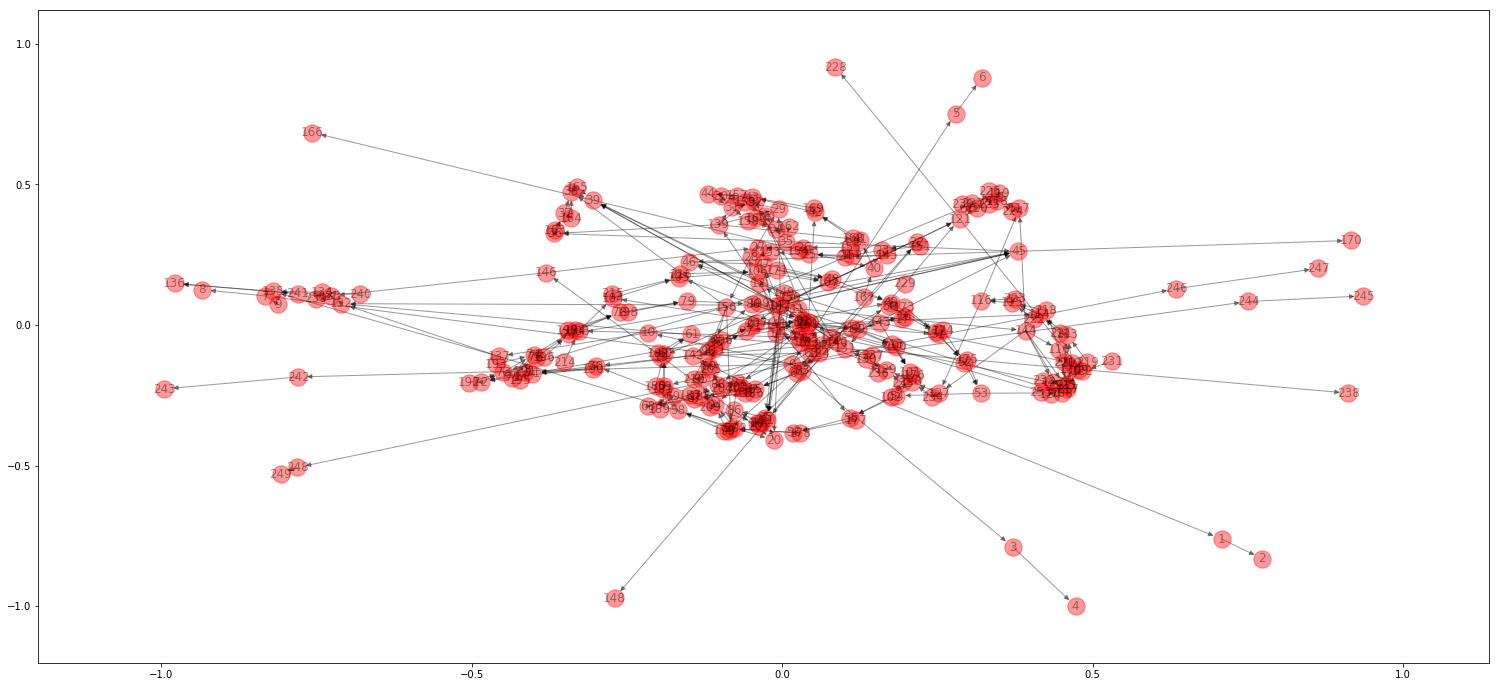

In [10]:
plt.figure(figsize=(26,12))
nx.draw_networkx(nx_graph, alpha=0.4)
plt.show()

# requires graphviz
#nx.drawing.nx_agraph.to_agraph(nx_graph).draw()

### GraphTuple example

In [11]:
# tuple example
graph_tup = graph_tuple.GraphTuple.CreateFromNetworkX(nx_graph)
print([a for a in dir(graph_tup) if '__' not in a])
print('\n')
print('edge_positions', [x.shape for x in graph_tup.edge_positions])

['CreateFromNetworkX', 'CreateFromProgramGraph', 'FromFile', 'FromGraphTuples', 'SetFeaturesAndLabels', 'ToFile', 'ToGraphTuples', 'ToNetworkx', '_asdict', '_field_defaults', '_field_types', '_fields', '_fields_defaults', '_make', '_replace', 'adjacencies', 'call_edge_count', 'control_edge_count', 'count', 'data_edge_count', 'disjoint_graph_count', 'disjoint_nodes_list', 'edge_count', 'edge_position_max', 'edge_positions', 'graph_x', 'graph_x_dimensionality', 'graph_y', 'graph_y_dimensionality', 'has_graph_x', 'has_graph_y', 'has_node_y', 'index', 'is_disjoint_graph', 'node_count', 'node_x', 'node_x_dimensionality', 'node_y', 'node_y_dimensionality']


edge_positions [(140,), (269,), (9,)]


### Collect Token distribution stats on the example

In [12]:
x = graph_tup.node_x.T.squeeze()


bins = np.bincount(x, minlength=8568)
s = np.sum(bins)
for i, c in enumerate(bins):
    if c:
        print(f"{i}  {c}   {(c*100/s):.3f}")

188  1   0.400
215  1   0.400
216  16   6.400
231  1   0.400
252  8   3.200
257  1   0.400
263  1   0.400
289  9   3.600
295  31   12.400
311  8   3.200
364  6   2.400
394  1   0.400
412  1   0.400
431  6   2.400
598  1   0.400
634  1   0.400
658  8   3.200
1122  3   1.200
3722  1   0.400
6277  6   2.400
8564  32   12.800
8565  106   42.400
8567  1   0.400


# Main: Preprocess Datasets

## Dev: tuple2data - GraphTuple -> Pyg data.Data

In [13]:
# data example
edge_indices = [torch.from_numpy(a).to(dtype=torch.long) for a in graph_tup.adjacencies] # list of <M_i, 2>
edge_types = [i * np.ones_like(edge_indices[i])[:,0] for i in range(len(edge_indices))]
edge_attr = np.hstack(edge_types)
print('edge_attr', edge_attr.shape)

t_attr = torch.from_numpy(edge_attr).to(dtype=torch.long).view(-1,1)
print(t_attr.size())
print('edge_indices', [x.shape for x in edge_indices])
print('edge_types', [x.shape for x in edge_types])

#edge_pos = [torch.from_numpy(a).to(dtype=torch.long) for a in graph_tup.edge_positions]
print('graph_tup.edge_positions', [x.shape for x in graph_tup.edge_positions])
edge_pos = np.hstack(graph_tup.edge_positions)

edge_attr = np.vstack([edge_attr, edge_pos])

edge_attr = torch.from_numpy(edge_attr.T).to(torch.long)
print('edge_attr', edge_attr.size())

# node_x as data.x
x = torch.from_numpy(graph_tup.node_x).to(torch.long) #
y = torch.from_numpy(np.array(42)).to(torch.long).view(1)
print('x', x.size())
print('y', y.size())

edge_attr (418,)
torch.Size([418, 1])
edge_indices [torch.Size([140, 2]), torch.Size([269, 2]), torch.Size([9, 2])]
edge_types [(140,), (269,), (9,)]
graph_tup.edge_positions [(140,), (269,), (9,)]
edge_attr torch.Size([418, 2])
x torch.Size([250, 1])
y torch.Size([1])


In [14]:
def tuple2data(graph_tup, class_label):
    # edges as data.edge_index
    # list of <M_i, 2> tensors  (M_i = num_edges for ith edge type)
    edge_indices = [torch.from_numpy(a).to(dtype=torch.long) for a in graph_tup.adjacencies] # list of <M_i, 2>

    edge_index = torch.cat(edge_indices, dim=0).t().contiguous() # <2, M>

    # (edge_type, edge_position) as data.edge_attr of shape <M, 2>
    edge_types = [i * np.ones_like(edge_indices[i])[:,0] for i in range(len(edge_indices))]
    edge_types = np.hstack(edge_types)
    edge_pos = np.hstack(graph_tup.edge_positions)
    edge_attr = np.vstack([edge_types, edge_pos]).T
    
    edge_attr = torch.from_numpy(edge_attr).to(dtype=torch.long).contiguous()  # <M, 2>
    
    assert edge_attr.size()[0] == edge_index.size()[1], f'edge_attr={edge_attr.size()} size mismatch with edge_index={edge_index.size()}'
    
    # node_x as data.x
    x = torch.from_numpy(graph_tup.node_x).to(torch.long)  # <N, 1>
    # class label as y
    y = torch.from_numpy(np.array(class_label)).to(torch.long).view(1)  # <1>

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

In [15]:
# tuple2data example
tuple2data(graph_tup, 42)

Data(edge_attr=[418, 2], edge_index=[2, 418], x=[250, 1], y=[1])

## Dev: nx2data (more flexible!)

### By Example

In [16]:
# inspect format
print(list(nx_graph.edges(data=True))[12])
list(nx_graph.nodes(data=True))[2]

(7, 8, {'position': 0, 'flow': 0})


(2,
 {'function': '__cxa_atexit',
  'type': 0,
  'text': '__cxa_atexit_exit',
  'preprocessed_text': '!UNK',
  'x': [8564],
  'y': []})

In [17]:
# Try to "update" the nx_graph.node.x:
from deeplearning.ml4pl.graphs.unlabelled.llvm2graph.node_encoder import GraphNodeEncoder

encoder = GraphNodeEncoder()

# this changes the nx_graph in-place!
encoder.EncodeNodes(nx_graph)

In [18]:
# collect edge_index
edge_index = torch.tensor(list(nx_graph.edges())).t().contiguous()
edge_index.size()

torch.Size([2, 418])

In [19]:
# collect edge attr
positions = []
flows = []
for i, (_, _, edge_data) in enumerate(nx_graph.edges(data=True)):
    positions.append(edge_data['position'])
    flows.append(edge_data['flow'])
positions = torch.tensor(positions)
flows = torch.tensor(flows)
edge_attr = torch.cat([flows, positions]).view(2, -1).t().contiguous()
edge_attr.size()


torch.Size([418, 2])

In [20]:
# collect node attributes
print(list(nx_graph.nodes(data=True))[0], '\n')
print(list(nx_graph.nodes(data=True))[27])


types = []
xs = []
for i, node_data in nx_graph.nodes(data=True):
    types.append(node_data['type'])
    xs.append(node_data['x'])
x = torch.cat([torch.tensor(xs), torch.tensor(xs)]).view(2, -1).t().contiguous()
x.size()


(0, {'type': 0, 'text': 'root', 'preprocessed_text': 'root', 'function': None, 'x': [8564], 'y': []}) 

(27, {'function': 'main', 'type': 0, 'text': 'store i8* %3, i8** %saved_stack', 'preprocessed_text': '<%ID> = alloca i32, i64 <%ID>, align 16', 'x': [8564], 'y': []})


torch.Size([250, 2])

### unit test on this example

### coalesce into nx2data function

In [27]:
def nx2data(nx_graph, class_label):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    # make sure the nx_graph is encoded properly (since node.x used to be buggy!)
    # encoder = GraphNodeEncoder()
    # encoder.EncodeNodes(nx_graph)

    # collect edge_index
    edge_index = torch.tensor(list(nx_graph.edges())).t().contiguous()

    # collect edge_attr
    positions = []
    flows = []

    for i, (_, _, edge_data) in enumerate(nx_graph.edges(data=True)):
        positions.append(edge_data['position'])
        flows.append(edge_data['flow'])

    positions = torch.tensor(positions)
    flows = torch.tensor(flows)

    edge_attr = torch.cat([flows, positions]).view(2, -1).t().contiguous()
    
    # collect x
    types = []
    xs = []
    
    for i, node_data in nx_graph.nodes(data=True):
        types.append(node_data['type'])
        xs.append(node_data['x'])

    print(xs)
    print(types)
    xs = torch.tensor(xs)
    types = torch.tensor(types)
    print(xs.size(), types.size())
    x = torch.cat([xs, types]).view(2, -1).t().contiguous()

    y = torch.tensor(int(class_label)).view(1)  # <1>
    
    assert edge_attr.size()[0] == edge_index.size()[1], f'edge_attr={edge_attr.size()} size mismatch with edge_index={edge_index.size()}'
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

In [28]:
# testing 
with open('71.ll', 'r') as f:
    ll = f.read()

nx_graph = builder.Build(ll)

with torch_geometric.debug():
    data = nx2data(nx_graph, 42)

graph_tup = graph_tuple.GraphTuple.CreateFromNetworkX(nx_graph)

data

[[8567], [8564], [8564], [8564], [8564], [8564], [8564], [8564], [8564], [8564], [8564], [8564], [8564], [231], [263], [8565], [289], [289], [289], [289], [289], [289], [289], [289], [289], [3722], [8564], [8564], [295], [311], [295], [188], [8564], [8564], [8564], [364], [216], [295], [295], [6277], [1122], [8564], [295], [252], [658], [8564], [216], [295], [431], [311], [216], [8564], [364], [364], [216], [295], [295], [6277], [1122], [8564], [216], [295], [252], [658], [295], [295], [412], [8564], [295], [311], [216], [295], [295], [6277], [1122], [8564], [295], [431], [252], [658], [295], [295], [252], [658], [311], [216], [295], [431], [311], [216], [295], [634], [8564], [295], [6277], [252], [658], [364], [216], [295], [6277], [252], [658], [364], [216], [295], [431], [311], [216], [216], [295], [431], [311], [216], [364], [216], [295], [295], [295], [598], [6277], [394], [8564], [295], [252], [658], [295], [8564], [216], [295], [431], [311], [216], [295], [252], [658], [295], [8

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 2 and 1 at /pytorch/aten/src/TH/generic/THTensor.cpp:680

In [ ]:
# unit test comparison on '71.ll'

golden_data = tuple2data(graph_tup, class_label=42)
print(golden_data)

# test edge_index
print(np.all(np.sort(golden_data.edge_index.numpy()) == np.sort(data.edge_index.numpy())))

# test edge_attr (loose test of plausibility)
print(np.all(np.sort(golden_data.edge_attr.numpy()[:,0]) == np.sort(data.edge_attr.numpy()[:,0])))
print(np.all(np.sort(golden_data.edge_attr.numpy()[:,1]) == np.sort(data.edge_attr.numpy()[:,1])))

# test node_x (can only test x and not type with golden!)
golden_x_sorted = np.sort(golden_data.x.numpy()[:,0])
x_sorted = np.sort(data.x.numpy()[:,0])
print(np.all(golden_x_sorted == x_sorted))
if not np.all(golden_x_sorted == x_sorted):
    print('-------')
    mask = golden_x_sorted != x_sorted
    print(f'golden_x_sorted[mask] =  {golden_x_sorted[mask]}')
    print(f'x_sorted[mask] =         {x_sorted[mask]}')

In [ ]:
from multiprocessing import Pool
import tqdm
import os

def dump(outfile, data, mkdir=True):
    if mkdir:
        outfile.parent.mkdir(exist_ok=True, parents=True)
    with open(outfile, 'wb') as f:
        pickle.dump(data, f)

def load(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

In [ ]:
def preprocess_ds_raw_dir(ds_base, dump_nx=True, dump_tuple=True, dump_data=True, pool_size=12):
    """Preprocess all .ll files in folders named by class ids e.g. ds_base/1, ds_base/2, ...
    into pytorch-geometric data.Data instances.
    
    The intermediate nx graphs and graph_tuples can be saved as well.
    """

    out_base = ds_base.parent / (ds_base.name + '_programl')
    out_base.mkdir(parents=True, exist_ok=True)
    problems = open(out_base / 'problems.txt', 'a')
    print(f"=== DATASET {ds_base}: preprocessing will be saved in {out_base}")

    # get all subfolders 1/ 2/ etc
    folders = [x for x in ds_base.glob('*') if x.is_dir()]

    for i, folder in enumerate(folders):
        try:
            int(folder.name)
        except ValueError as e:
            print(f"Folder {i} has to be named with integervalues, but is {folder.name}.")
            raise e
    
    # multiprocessed loop over folders
    pool = Pool(processes=pool_size)
    task_args = [(folder, dump_nx, dump_tuple, dump_data, out_base) for folder in folders]
    
    for probs in tqdm.tqdm(pool.imap_unordered(_process_single_folder, task_args), total=len(task_args)):
        if len(probs) > 15: # don't print empty strings like '\n\n\n'
            print(probs, file=problems)
    
    pool.close()
    pool.join()

    problems.close()
    print(f" * COMPLETED * === DATASET {ds_base}: preprocessing saved to {out_base}")
    
    

In [ ]:
def _process_single_folder(args):
    """The new version will skip tuple creation completely."""
    folder, dump_nx, dump_tuple, dump_data, out_base = args
    del dump_tuple
    
    problems = ""
    
    print(f"=== Opening Folder {str(folder)} ===")
    
    label = int(folder.name)
    files = list(folder.glob('*.ll'))
    
    # iterate over all .ll files in folder and confirm and respectively create the .nx.p and .data.p files
    for i, file in enumerate(files):
        outfile_nx = out_base / '_nx' / folder.name / (file.name.rsplit('.', 1)[0] + '.nx.p')
        outfile_data = out_base / folder.name / (file.name.rsplit('.', 1)[0] + '.data.p')

        # find out where to start processing

        # skip entirely?
        if outfile_data.is_file():
            continue

        # start at step 2: nx --> data ?
        if outfile_nx.is_file():
            nx_graph = load(outfile_nx)            
            data = nx2data(nx_graph, class_label=label)
            dump(outfile_data, data)
            
            # TODO: delete this line soon !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # also write back nx_file because the tokenization has been bug-fixed!
            # dump(outfile_nx, nx_graph)
            continue
        
        # start in the beginning:
        # ~~~ step 1: .ll --> nx ~~~
        if i % 100 == 0:
            print(f"{folder.name} - [{i}/{len(files)}] Processing {str(file)} ...")
        
        with open(file, 'r') as f:
            bytecode = f.read()

        try:
            nx_graph = builder.Build(bytecode) # nx
            if dump_nx:
                dump(outfile_nx, nx_graph)
        except:
            print(f"***** FAILING ON {str(file)} ... renaming file to .ll_ ")
            problems += str(file)
            problems += '\n'
            file.rename(file.with_suffix('.ll_'))
            continue

        # step 2: nx --> data
        data = nx2data(nx_graph, class_label=label)
        dump(outfile_data, data)

    return problems

In [ ]:
def _process_single_folder_deprecated(args):
    folder, dump_nx, dump_tuple, dump_data, out_base = args
    problems = ""
    
    print(f"=== Opening Folder {str(folder)} ===")
    
    label = int(folder.name)
    files = list(folder.glob('*.ll'))
    for i, file in enumerate(files):
        outfile_nx = out_base / '_nx' / folder.name / (file.name.rsplit('.', 1)[0] + '.nx.p')
        outfile_tuple = out_base / '_tuples' / folder.name / (file.name.rsplit('.', 1)[0] + '.tuple.p')
        outfile_data = out_base / folder.name / (file.name.rsplit('.', 1)[0] + '.data.p')

        # find out where to start processing

        # skip entirely?
        if outfile_data.is_file():
            continue

        # start at step 3: tuple -> data?
        if outfile_tuple.is_file():
            graph_tup = load(outfile_tuple)
            
            # ~~~ step 3: tuple --> data ~~~
            data = tuple2data(graph_tup, class_label=label)
            dump(outfile_data, data)
            continue

        # start at step 2: nx --> tuple ?
        if outfile_nx.is_file():
            nx_graph = load(outfile)
            
            # ~~~ step 2: nx --> tuple ~~~
            graph_tup = graph_tuple.GraphTuple.CreateFromNetworkX(nx_graph)
            if dump_tuple:
                dump(outfile_tuple, graph_tup)
            
            # step 3: tuple --> data            
            data = tuple2data(graph_tup, class_label=label)
            dump(outfile_data, data)
            continue
        
        # start in the beginning:
        # ~~~ step 1: .ll --> nx ~~~
        if i % 100 == 0:
            print(f"{folder.name} - [{i}/{len(files)}] Processing {str(file)} ...")
        
        with open(file, 'r') as f:
            bytecode = f.read()

        try:
            nx_graph = builder.Build(bytecode) # nx
            if dump_nx:
                dump(outfile, nx_graph)
        except:
            print(f"***** FAILING ON {str(file)} ... renaming file to .ll_ ")
            problems += str(file)
            problems += '\n'
            file.rename(file.with_suffix('.ll_'))
            continue

        # step 2: nx --> tuple
        graph_tup = graph_tuple.GraphTuple.CreateFromNetworkX(nx_graph)
        if dump_tuple:
            dump(outfile_tuple, graph_tup)

        # step 3: tuple --> data            
        data = tuple2data(graph_tup, class_label=label)
        dump(outfile_data, data)

    return problems

In [ ]:
# download dataset if needed
import wget
import zipfile

def download_and_unzip(url, dataset_name, data_folder):
    """
    Download and unzip data set folder from url
    :param url: from which to download
    :param dataset_name: name of data set (for printing)
    :param data_folder: folder in which to put the downloaded data
    """
    print('Downloading', dataset_name, 'data set...')
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    data_zip = wget.download(url, out=data_folder)
    print('\tunzipping...')
    zip_ = zipfile.ZipFile(data_zip, 'r')
    assert os.path.isdir(data_folder), data_folder
    zip_.extractall(data_folder)
    zip_.close()
    print('\tdone')

def download_classifyapp(dataset_path):
    # get Path object
    if type(dataset_path) == str:
        dataset_path = Path(dataset_path)
    dataset_path = dataset_path / 'classifyapp_data'
        
    # Acquire data
    if not dataset_path.exists():
        dataset_path.mkdir(parents=True)
        download_and_unzip('https://polybox.ethz.ch/index.php/s/JOBjrfmAjOeWCyl/download',
                                      'classifyapp_data', str(dataset_path.absolute()))
    else:
        print(f'skipped downloading to {str(dataset_path.absolute())}')

## *needs action:*

In [ ]:
!pwd

In [ ]:
# Set where to store the dataset and download automagically
ds_basepath = Path('/mnt/data/llvm/master_thesis_datasets')

# uncomment this line to save data "in place"
#ds_basepath = Path(repo_root) / 'deeplearning/ml4pl/poj104'

logs_basepath = ds_basepath / 'classifyapp_logs'

ds_basepath.mkdir(parents=True, exist_ok=True)
logs_basepath.mkdir(parents=True, exist_ok=True)

download_classifyapp(ds_basepath)

In [ ]:
# link those places into poj104 folder

data_source = str((ds_basepath / 'classifyapp_data').absolute())
print(data_source)
data_target = repo_root + '/deeplearning/ml4pl/poj104/'
print(data_target)

logs_source = str(logs_basepath.absolute())
print(logs_source)
logs_target = repo_root + '/deeplearning/ml4pl/poj104/'
print(logs_target)

In [ ]:
! ln -s {data_source} {data_target}
! ln -s {logs_source} {logs_target}
! ls -lah {str(repo_root + '/deeplearning/ml4pl/poj104')} | grep classifyapp

### Process validation set

In [ ]:
# start processing the smaller validation dataset
dataset_path = ds_basepath / Path('classifyapp_data/rerunning_val_test_data/ir_val')
print(dataset_path.name)

preprocess_ds_raw_dir(dataset_path, pool_size=16)

### Process test set

In [ ]:
# test dataset
dataset_path = ds_basepath / Path('classifyapp_data/rerunning_val_test_data/ir_test')
print(dataset_path.name)

preprocess_ds_raw_dir(dataset_path, pool_size=16)

### Process train set

In [ ]:
# train dataset
dataset_path = ds_basepath / Path('classifyapp_data/ir_train')
print(dataset_path.name)

preprocess_ds_raw_dir(dataset_path, pool_size=16)

# Development of Pytorch-Geometric Dataset

In [ ]:
# naive dataloader that works on a list of data.Data instances in memory.

def get_dataloader(self, ds_base, config):
    ds_base = Path(ds_base) if type(ds_base) is str else ds_base
    datalist = []
    out_base = ds_base.parent / (ds_base.name + "_programl")
    print(f"=== DATASET {ds_base}: getting dataloader")

    folders = [x for x in out_base.glob("*") if x.is_dir() and x.name not in ['_nx', '_tuples']]
    for folder in tqdm.tqdm(folders):
        # skip classes that are larger than what config says to enable debugging with less data
        if int(folder.name) > config.num_classes:
            continue
        # print(f"=== Opening Folder {str(folder)} ===")
        for k, file in enumerate(folder.glob("*.data.p")):
            # print(f"{k} - Processing {str(file)} ...")
            with open(file, "rb") as f:
                data = pickle.load(f)
            datalist.append(data)
    print(f" * COMPLETED * === DATASET {ds_base}: returning dataloader")
    return DataLoader(datalist, batch_size=config.batch_size, shuffle=True)


# Finished Dataset

In [ ]:
from deeplearning.ml4pl.poj104.dataset import POJ104Dataset

In [ ]:
#raw_data_path = '/mnt/data/llvm/master_thesis_datasets/classifyapp_data/'
raw_data_path = repo_root + '/deeplearning/ml4pl/poj104/classifyapp_data'
print(raw_data_path)

In [ ]:
POJ104Dataset()

# TBD: upcoming work section